Material for the book [Probability and Statistics for Data Science](https://a.co/d/cAss9mO). A free preprint, videos, code, slides and solutions to exercises are available at https://www.ps4ds.net/

Code for Figures 6.7

Diagnosis of Alzheimer's disease using features representing volumes of two brain regions (hippocampus and entorhinal cortes) extracted from magnetic resonance imaging scans.\
Topics and relevant videos: [Classification](https://www.youtube.com/watch?v=pfIPwD2mWbo), [Gaussian random vectors](https://www.youtube.com/watch?v=adr_EwRaLbk), [Gaussian discriminant analysis, quadratic discriminant analysis, linear discriminant analysis](https://www.youtube.com/watch?v=F-Qj-W47TzQ)

Author: Carlos Fernandez-Granda
Data source: https://github.com/NYUMedML/CNN_design_for_AD/tree/master/datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
from scipy.stats import norm
import matplotlib 
matplotlib.rcParams['text.usetex'] = True
from matplotlib.lines import Line2D

font_size = 15
font_size_legend = 15
font_size_ticks = 15

# train_set = pd.read_csv ("../data/alzheimers/ADNI_train_volumes.tsv", sep = ',')
# test_set = pd.read_csv ("../data/alzheimers/ADNI_val_volumes.tsv", sep = ',')
# nacc_set = pd.read_csv ("../data/alzheimers/NACC_volumes.tsv", sep = ',')

# Raw GitHub URLs
url_train = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/alzheimers/ADNI_train_volumes.tsv"
url_test = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/alzheimers/ADNI_val_volumes.tsv"
url_nacc = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/alzheimers/NACC_volumes.tsv"

# Load and clean data
train_set = pd.read_csv(url_train, sep=',')
train_set.dropna(subset=['Left-Hippocampus'], inplace=True)

# This test set can be used for in-distribution evaluation; here we only do OOD evaluation on the NACC cohort
test_set = pd.read_csv(url_test, sep=',')
test_set.dropna(subset=['Left-Hippocampus'], inplace=True)

nacc_set = pd.read_csv(url_nacc, sep=',')
nacc_set.dropna(subset=['Left-Hippocampus'], inplace=True)

labels_train = train_set["diagnosis"]
labels_nacc = nacc_set["diagnosis"]
print("Training examples: " + str(len(labels_train)))
print("Fraction of Alzheimer's disease (AD): " + str(np.round(pd.Series(labels_train).value_counts()["AD"] / len(labels_train),3)))
print("NACC test examples: " + str(len(labels_nacc)))
print("Fraction of AD: " + str(np.round(pd.Series(labels_nacc).value_counts()["AD"] / len(labels_nacc),3)))

Training examples: 1936
Fraction of Alzheimer's disease (AD): 0.271
NACC test examples: 2045
Fraction of AD: 0.216


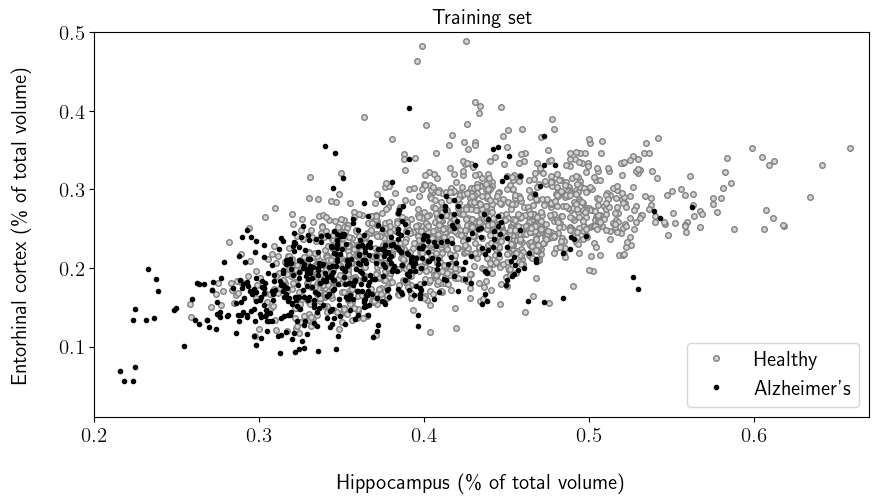

In [2]:
# The two features are the volume of the hippocampus and of the entorhinal cortex, normalized by the total brain volume 
total_volume_train = train_set["EstimatedTotalIntraCranialVol"]
hippocampus_train = (train_set["Left-Hippocampus"] + train_set["Right-Hippocampus"]) 
entorhinal_train = (train_set["lh_entorhinal_volume"] + train_set["rh_entorhinal_volume"]) 
hippocampus_norm_train = hippocampus_train/total_volume_train * 100
entorhinal_norm_train = entorhinal_train/total_volume_train * 100

hippocampus_norm_notAD_train = np.array(hippocampus_norm_train[labels_train.isin(["CN","MCI"])])
hippocampus_norm_AD_train = np.array(hippocampus_norm_train[labels_train=="AD"])
entorhinal_norm_notAD_train = np.array(entorhinal_norm_train[labels_train.isin(["CN","MCI"])])
entorhinal_norm_AD_train = np.array(entorhinal_norm_train[labels_train=="AD"])

min_hippocampus = 0.2
max_hippocampus = 0.67
min_entorhinal = 0.01
max_entorhinal = 0.5

markersize = 4
plt.figure(figsize=(10,5))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(hippocampus_norm_notAD_train,entorhinal_norm_notAD_train, 'o',markersize=markersize,markerfacecolor='lightgray',markeredgecolor="gray",
         label='Healthy')
plt.plot(hippocampus_norm_AD_train,entorhinal_norm_AD_train, 'o',markersize=markersize-1,markerfacecolor='black',markeredgecolor="black",
         label='Alzheimer\'s')
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal])
plt.xlabel("Hippocampus (\% of total volume)",fontsize=font_size,labelpad=20)
plt.ylabel('Entorhinal cortex (\% of total volume)',fontsize=font_size,labelpad=20)
plt.legend(fontsize=font_size,loc="lower right")
plt.title("Training set",fontsize=font_size);

In [3]:
# We extract the same features from the NACC independent test set
total_volume_nacc = nacc_set["EstimatedTotalIntraCranialVol"]
hippocampus_nacc = (nacc_set["Left-Hippocampus"] + nacc_set["Right-Hippocampus"])
entorhinal_nacc = (nacc_set["lh_entorhinal_volume"] + nacc_set["rh_entorhinal_volume"])
hippocampus_norm_nacc = hippocampus_nacc/total_volume_nacc * 100
entorhinal_norm_nacc = entorhinal_nacc/total_volume_nacc * 100

hippocampus_norm_notAD_nacc = np.array(hippocampus_norm_nacc[labels_nacc.isin(["CN","MCI"])])
hippocampus_norm_AD_nacc = np.array(hippocampus_norm_nacc[labels_nacc=="AD"])
entorhinal_norm_notAD_nacc = np.array(entorhinal_norm_nacc[labels_nacc.isin(["CN","MCI"])])
entorhinal_norm_AD_nacc = np.array(entorhinal_norm_nacc[labels_nacc=="AD"])

In [4]:
# 2D grid of feature values
hippocampus_aux = np.linspace(min_hippocampus, max_hippocampus, 50)  
entorhinal_aux = np.linspace(min_entorhinal, max_entorhinal, 50) 
hippocampus_grid, entorhinal_grid = np.meshgrid(hippocampus_aux, entorhinal_aux)

# 2D Gaussian density
def gaussian(x,y,mu,invSigma,Sigma):
    return (np.exp(-(invSigma[0,0] * (x-mu[0])**2 + 2*invSigma[0,1]*(x-mu[0])*(y-mu[1]) + invSigma[1,1] * (y-mu[1])**2)/2)
                  /(2 * np.pi * np.sqrt(np.linalg.det(Sigma))))
# Auxiliary function
def fmt(x):
    s = f"{x:.4f}"
    if s.endswith("0"):
        s = f"{x:.2f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

Mean Alzheimer's [0.35700701 0.19508768]
Covariance matrix Alzheimer's [[0.00316444 0.00145677]
 [0.00145677 0.00245009]]
Mean healthy [0.42141207 0.24373239]
Covariance matrix healthy [[0.00443332 0.00196672]
 [0.00196672 0.00276774]]


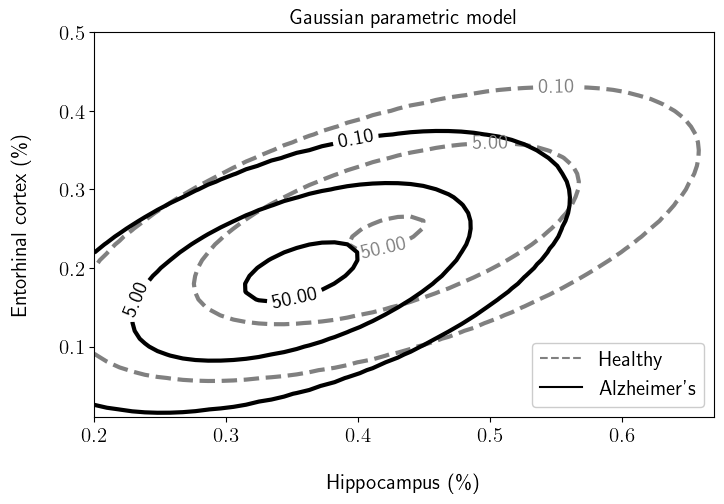

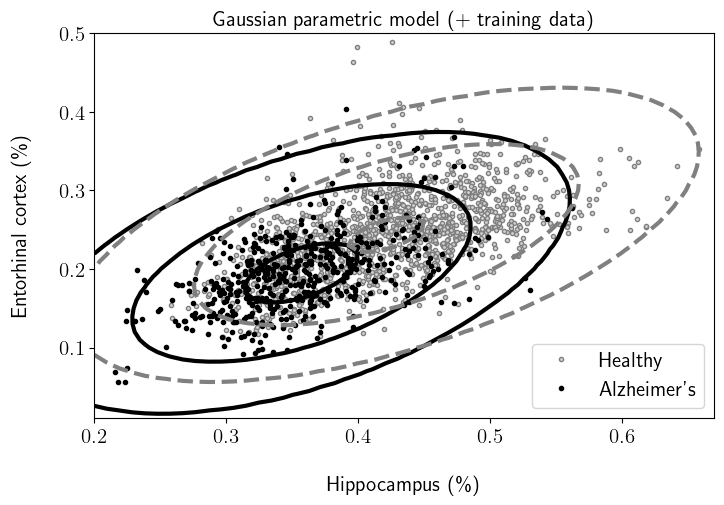

In [5]:
# Maximum-likelihood estimate of Gaussian parameters for AD patients
features_AD_train = np.vstack((hippocampus_norm_AD_train,entorhinal_norm_AD_train))
mu_AD = np.mean(features_AD_train,axis=1)
Sigma_AD = np.cov(features_AD_train)
print("Mean Alzheimer's",mu_AD)
print("Covariance matrix Alzheimer's",Sigma_AD)
invSigma_AD = np.linalg.inv(Sigma_AD)
z_gaussian_AD = gaussian(hippocampus_grid, entorhinal_grid,mu_AD,invSigma_AD,Sigma_AD)

# Maximum-likelihood estimate of Gaussian parameters for non-AD subjects
features_notAD_train = np.vstack((hippocampus_norm_notAD_train,entorhinal_norm_notAD_train))
mu_notAD = np.mean(features_notAD_train,axis=1)
Sigma_notAD = np.cov(features_notAD_train)
print("Mean healthy",mu_notAD)
print("Covariance matrix healthy",Sigma_notAD)
invSigma_notAD = np.linalg.inv(Sigma_notAD)
z_gaussian_notAD = gaussian(hippocampus_grid, entorhinal_grid,mu_notAD,invSigma_notAD,Sigma_notAD)

levels_gaussian = [0.1,5,50]
alpha = 0.25

plt.figure(figsize=(8,5))
manual_locations_notAD = [(0.55, 0.45), (0.5, 0.35), (0.42, 0.22)]
manual_locations_AD = [(0.4, 0.35), (0.22, 0.17), (0.35, 0.18)]
CS_notAD = plt.contour(hippocampus_grid, entorhinal_grid,z_gaussian_notAD, levels=levels_gaussian,
                       colors='gray',linestyles='dashed',linewidths=3)
CS_AD = plt.contour(hippocampus_grid, entorhinal_grid,z_gaussian_AD, levels=levels_gaussian,
                    colors='black',linewidths=3)
plt.clabel(CS_AD, CS_AD.levels, inline=True, fmt=fmt,fontsize=font_size_ticks, manual=manual_locations_AD)
plt.clabel(CS_notAD, CS_notAD.levels, inline=True, fmt=fmt,fontsize=font_size_ticks, manual=manual_locations_notAD)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal])
plt.xlabel("Hippocampus (\%)",fontsize=font_size,labelpad=20)
plt.ylabel('Entorhinal cortex (\%)',fontsize=font_size,labelpad=20)
healthy_proxy = Line2D([0], [0], color=CS_notAD.cmap(0.5),ls="dashed", label="Healthy")
AD_proxy = Line2D([0], [0], color=CS_AD.cmap(0.5), label="Alzheimer\'s")
plt.legend(handles=[healthy_proxy,AD_proxy], fontsize=font_size, framealpha=1, loc="lower right")
plt.title("Gaussian parametric model",fontsize=font_size)

markersize = 3
plt.figure(figsize=(8,5))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(hippocampus_norm_notAD_train,entorhinal_norm_notAD_train, 'o',markersize=markersize,markerfacecolor='lightgray',markeredgecolor="gray",
         label='Healthy',alpha=1)
plt.plot(hippocampus_norm_AD_train,entorhinal_norm_AD_train, 'o',markersize=markersize,markerfacecolor='black',markeredgecolor="black",
         label='Alzheimer\'s',alpha=1)
CS_AD = plt.contour(hippocampus_grid, entorhinal_grid,z_gaussian_AD, levels=levels_gaussian,colors='black',linewidths=3)
CS_notAD = plt.contour(hippocampus_grid, entorhinal_grid,z_gaussian_notAD, levels=levels_gaussian,colors='gray',linestyles='dashed',linewidths=3)
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal])
plt.xlabel("Hippocampus (\%)",fontsize=font_size,labelpad=20)
plt.ylabel('Entorhinal cortex (\%)',fontsize=font_size,labelpad=20)
plt.legend(fontsize=font_size,loc="lower right")
plt.title("Gaussian parametric model (+ training data)",fontsize=font_size);

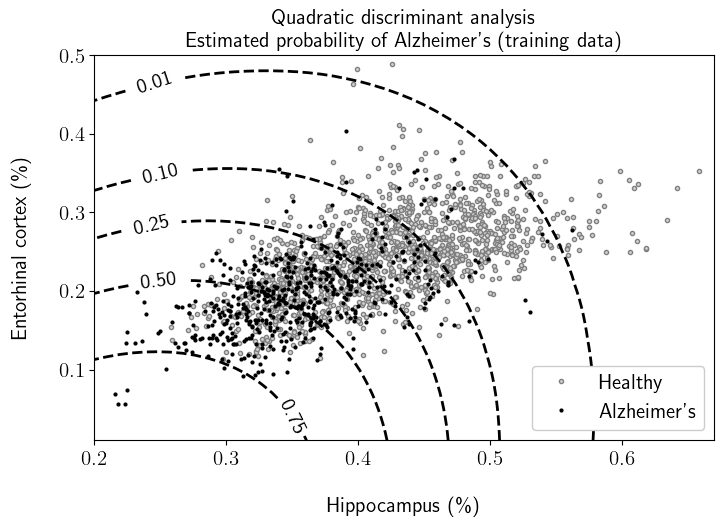

In [6]:
p_AD = pd.Series(labels_train).value_counts()["AD"] / len(labels_train)
# Conditional probability of Alzheimer's given the features, computed via Bayes' rule for discrete and continuous random variables
# The pdf of the continuous random variables representing the features is estimated using the Gaussian parametric model
def conditional_p_AD(x,y):
    p = p_AD * gaussian(x,y,mu_AD,invSigma_AD,Sigma_AD) / (
        p_AD * gaussian(x,y,mu_AD,invSigma_AD,Sigma_AD) +
        (1-p_AD) * gaussian(x,y,mu_notAD,invSigma_notAD,Sigma_notAD) )
    return p

cond_prob_AD = conditional_p_AD(hippocampus_grid,entorhinal_grid)

levels_p = [0.01,0.1,0.25,0.5,0.75]
plt.figure(figsize=(8,5))
plt.plot(hippocampus_norm_notAD_train,entorhinal_norm_notAD_train, 'o',markersize=markersize,markerfacecolor='lightgray',markeredgecolor="gray",
         label='Healthy',alpha=1)
plt.plot(hippocampus_norm_AD_train,entorhinal_norm_AD_train, 'o',markersize=markersize-1,markerfacecolor='black',markeredgecolor="black",
         label='Alzheimer\'s',alpha=1)
CS = plt.contour(hippocampus_grid,entorhinal_grid, cond_prob_AD,levels= levels_p,
                 colors='black',linewidths=2,linestyles="dashed")
manual_locations = [(0.25, 0.45), (0.25, 0.35), (0.25, 0.25), (0.25, 0.2),(0.35, 0.04)]
plt.clabel(CS, CS.levels, inline=True, fontsize=font_size_ticks,inline_spacing=3, rightside_up=True,fmt='%1.2f'
          ,manual=manual_locations)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal])
plt.xlabel("Hippocampus (\%)",fontsize=font_size,labelpad=20)
plt.ylabel('Entorhinal cortex (\%)',fontsize=font_size,labelpad=20)
plt.legend(fontsize=font_size,framealpha=1,loc="lower right")
plt.title("Quadratic discriminant analysis\nEstimated probability of Alzheimer's (training data)",fontsize=font_size);

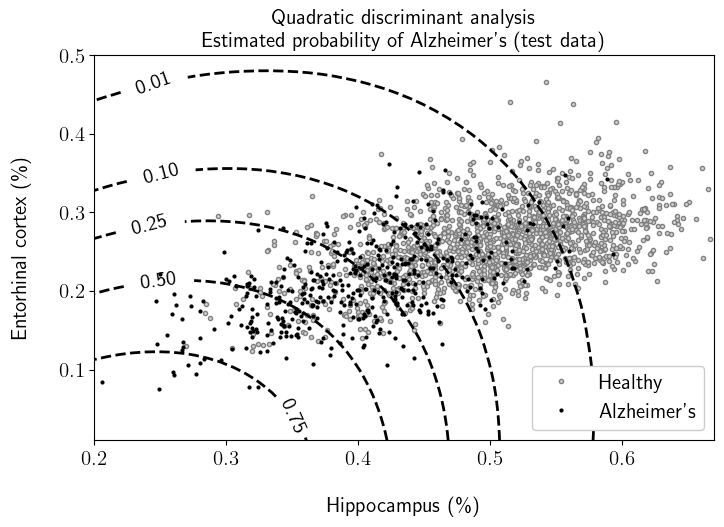

In [7]:
levels_p = [0.01,0.1,0.25,0.5,0.75,0.9]
plt.figure(figsize=(8,5))
plt.plot(hippocampus_norm_notAD_nacc,entorhinal_norm_notAD_nacc, 'o',markersize=markersize,markerfacecolor='lightgray',markeredgecolor="gray",
         label='Healthy',alpha=1)
plt.plot(hippocampus_norm_AD_nacc,entorhinal_norm_AD_nacc, 'o',markersize=markersize-1,markerfacecolor='black',markeredgecolor="black",
         label='Alzheimer\'s',alpha=1)
CS = plt.contour(hippocampus_grid,entorhinal_grid,cond_prob_AD, levels=levels_p,colors='black',linewidths=2,linestyles="dashed")
manual_locations = [(0.25, 0.45), (0.25, 0.35), (0.25, 0.25), (0.25, 0.2),(0.35, 0.04)]
plt.clabel(CS, CS.levels, inline=True, fontsize=font_size_ticks,inline_spacing=3, rightside_up=True,fmt='%1.2f'
          ,manual=manual_locations)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal])
plt.xlabel("Hippocampus (\%)",fontsize=font_size,labelpad=20)
plt.ylabel('Entorhinal cortex (\%)',fontsize=font_size,labelpad=20)
plt.legend(fontsize=font_size,framealpha=1,loc="lower right")
plt.title("Quadratic discriminant analysis\nEstimated probability of Alzheimer's (test data)",fontsize=font_size);

In [8]:
def evaluate_QDA(hippocampus_norm_AD,entorhinal_norm_AD,hippocampus_norm_notAD,entorhinal_norm_notAD,threshold):
    
    AD_predicted_as_AD = 0
    AD_predicted_as_notAD = 0
    notAD_predicted_as_notAD = 0
    notAD_predicted_as_AD = 0
    
    for ind in range(len(hippocampus_norm_AD)):
        if conditional_p_AD(hippocampus_norm_AD[ind],entorhinal_norm_AD[ind]) > threshold:
            AD_predicted_as_AD += 1
        else:
            AD_predicted_as_notAD += 1
    for ind in range(len(hippocampus_norm_notAD)):
        if conditional_p_AD(hippocampus_norm_notAD[ind],entorhinal_norm_notAD[ind]) > threshold:
            notAD_predicted_as_AD += 1
        else:
            notAD_predicted_as_notAD += 1
    accuracy = (AD_predicted_as_AD + notAD_predicted_as_notAD)/(
        AD_predicted_as_AD + notAD_predicted_as_notAD + AD_predicted_as_notAD 
        + notAD_predicted_as_AD)
    return [accuracy, AD_predicted_as_AD, AD_predicted_as_notAD,notAD_predicted_as_notAD,notAD_predicted_as_AD]

# We use 0.5 as a threshold, but this is an arbitrary choice!
thresh = 0.5
[accuracy_train, AD_predicted_as_AD_train, AD_predicted_as_notAD_train,
 notAD_predicted_as_notAD_train,notAD_predicted_as_AD_train] = evaluate_QDA(hippocampus_norm_AD_train,entorhinal_norm_AD_train,
                                                                           hippocampus_norm_notAD_train,entorhinal_norm_notAD_train,thresh)

print("Evaluation of quadratic discriminant analysis on the training set")
print("AD predicted as AD: " + str(AD_predicted_as_AD_train))
print("AD predicted as not AD: " + str(AD_predicted_as_notAD_train))
print("not AD predicted as not AD: " + str(notAD_predicted_as_notAD_train))
print("not AD predicted as AD: " + str(notAD_predicted_as_AD_train))
print("Accuracy: " + str(np.round(accuracy_train,3)))

[accuracy_nacc, AD_predicted_as_AD_nacc, AD_predicted_as_notAD_nacc,
 notAD_predicted_as_notAD_nacc,notAD_predicted_as_AD_nacc] = evaluate_QDA(hippocampus_norm_AD_nacc,entorhinal_norm_AD_nacc,
                                                                           hippocampus_norm_notAD_nacc,entorhinal_norm_notAD_nacc,thresh)

print("Evaluation of quadratic discriminant analysis on the test set")
print("AD predicted as AD: " + str(AD_predicted_as_AD_nacc))
print("AD predicted as not AD: " + str(AD_predicted_as_notAD_nacc))
print("not AD predicted as not AD: " + str(notAD_predicted_as_notAD_nacc))
print("not AD predicted as AD: " + str(notAD_predicted_as_AD_nacc))
print("Accuracy: " + str(np.round(accuracy_nacc,3)))

Evaluation of quadratic discriminant analysis on the training set
AD predicted as AD: 203
AD predicted as not AD: 322
not AD predicted as not AD: 1261
not AD predicted as AD: 145
Accuracy: 0.758
Evaluation of quadratic discriminant analysis on the test set
AD predicted as AD: 94
AD predicted as not AD: 348
not AD predicted as not AD: 1573
not AD predicted as AD: 30
Accuracy: 0.815


Common covariance matrix [[0.00408652 0.00182725]
 [0.00182725 0.00268007]]


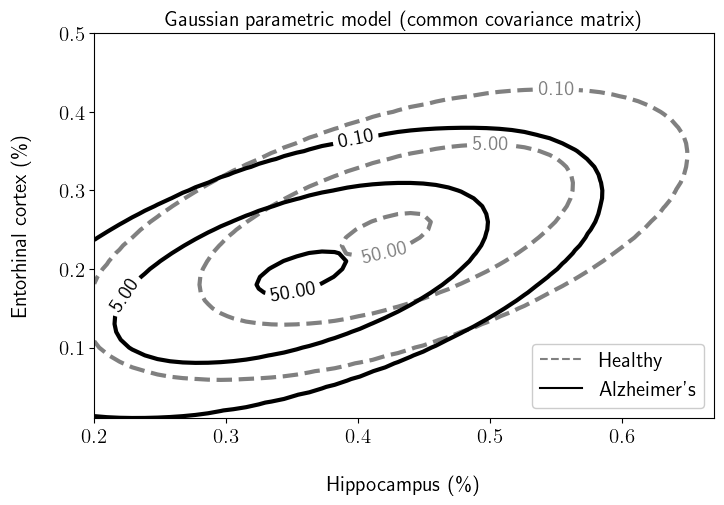

In [9]:
# Gaussian fit via maximum likelihood estimation assuming the covariance-matrix parameter is the same for AD patients and healthy subjects
mu_AD_vec = np.mean(features_AD_train,axis=1, keepdims=True)
mu_notAD_vec = np.mean(features_notAD_train,axis=1, keepdims=True)
centered_features_AD = features_AD_train-mu_AD_vec
centered_features_notAD = features_notAD_train-mu_notAD_vec
centered_features = np.concatenate((centered_features_AD,centered_features_notAD),axis=1)
Sigma = np.cov(centered_features)
invSigma = np.linalg.inv(Sigma)
print("Common covariance matrix",Sigma)

z_gaussian_AD_LDA = gaussian(hippocampus_grid, entorhinal_grid,mu_AD,invSigma,Sigma)
z_gaussian_notAD_LDA = gaussian(hippocampus_grid, entorhinal_grid,mu_notAD,invSigma,Sigma)

levels_gaussian = [0.1,5,50]
alpha = 0.25
manual_locations_notAD = [(0.55, 0.45), (0.5, 0.35), (0.42, 0.22)]
manual_locations_AD = [(0.4, 0.35), (0.22, 0.17), (0.35, 0.18)]

plt.figure(figsize=(8,5))
manual_locations_notAD = [(0.55, 0.45), (0.5, 0.35), (0.42, 0.22)]
manual_locations_AD = [(0.4, 0.35), (0.22, 0.17), (0.35, 0.18)]
CS_notAD = plt.contour(hippocampus_grid, entorhinal_grid,z_gaussian_notAD_LDA, levels=levels_gaussian,
                       colors='gray',linestyles='dashed',linewidths=3)
CS_AD = plt.contour(hippocampus_grid, entorhinal_grid,z_gaussian_AD_LDA, levels=levels_gaussian,
                    colors='black',linewidths=3)
plt.clabel(CS_AD, CS_AD.levels, inline=True, fmt=fmt,fontsize=font_size_ticks, manual=manual_locations_AD)
plt.clabel(CS_notAD, CS_notAD.levels, inline=True, fmt=fmt,fontsize=font_size_ticks, manual=manual_locations_notAD)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal])
plt.xlabel("Hippocampus (\%)",fontsize=font_size,labelpad=20)
plt.ylabel('Entorhinal cortex (\%)',fontsize=font_size,labelpad=20)
healthy_proxy = Line2D([0], [0], color=CS_notAD.cmap(0.5),ls="dashed", label="Healthy")
AD_proxy = Line2D([0], [0], color=CS_AD.cmap(0.5), label="Alzheimer\'s")
plt.legend(handles=[healthy_proxy,AD_proxy], fontsize=font_size, framealpha=1, loc="lower right")
plt.title("Gaussian parametric model (common covariance matrix)",fontsize=font_size);

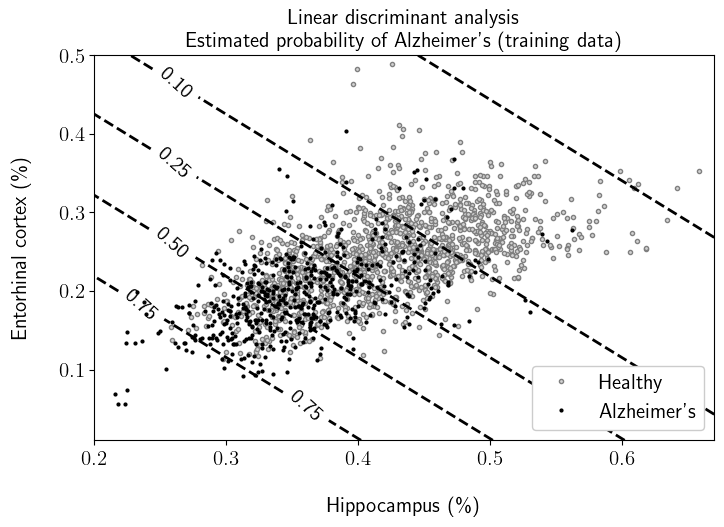

In [10]:
# Conditional probability of Alzheimer's given the features, computed via Bayes' rule for discrete and continuous random variables
# The pdf of the continuous random variables is estimated using the Gaussian parametric model with common covariance matrix
def conditional_p_AD_LDA(x,y):
    p = p_AD * gaussian(x,y,mu_AD,invSigma,Sigma) / (
        p_AD * gaussian(x,y,mu_AD,invSigma,Sigma) +
        (1-p_AD) * gaussian(x,y,mu_notAD,invSigma,Sigma) )
    return p

cond_prob_AD_LDA = conditional_p_AD_LDA(hippocampus_grid,entorhinal_grid)

levels_p = [0.01,0.1,0.25,0.5,0.75]
plt.figure(figsize=(8,5))
plt.plot(hippocampus_norm_notAD_train,entorhinal_norm_notAD_train, 'o',markersize=markersize,markerfacecolor='lightgray',markeredgecolor="gray",
         label='Healthy',alpha=1)
plt.plot(hippocampus_norm_AD_train,entorhinal_norm_AD_train, 'o',markersize=markersize-1,markerfacecolor='black',markeredgecolor="black",
         label='Alzheimer\'s',alpha=1)
CS = plt.contour(hippocampus_grid,entorhinal_grid, cond_prob_AD_LDA,levels= levels_p,
                 colors='black',linewidths=2,linestyles="dashed")
manual_locations = [(0.25, 0.45), (0.25, 0.35), (0.25, 0.25), (0.25, 0.2),(0.35, 0.04)]
plt.clabel(CS, CS.levels, inline=True, fontsize=font_size_ticks,inline_spacing=3, rightside_up=True,fmt='%1.2f'
          ,manual=manual_locations)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal])
plt.xlabel("Hippocampus (\%)",fontsize=font_size,labelpad=20)
plt.ylabel('Entorhinal cortex (\%)',fontsize=font_size,labelpad=20)
plt.legend(fontsize=font_size,framealpha=1,loc="lower right")
plt.title("Linear discriminant analysis\nEstimated probability of Alzheimer's (training data)",fontsize=font_size);

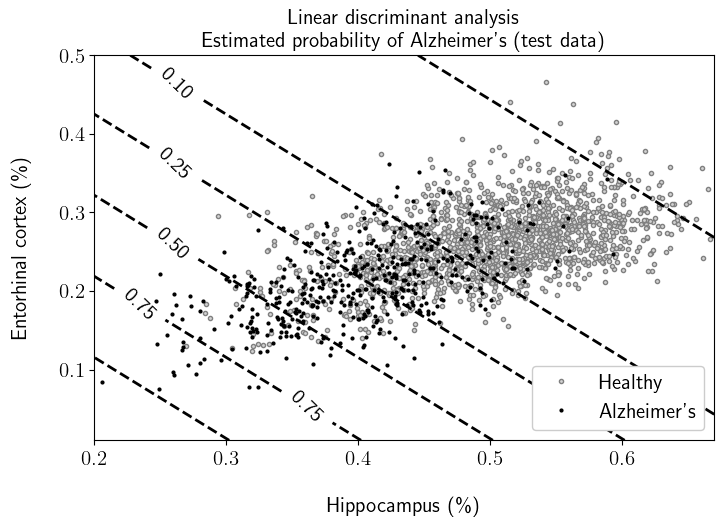

In [11]:
levels_p = [0.01,0.1,0.25,0.5,0.75,0.9]
plt.figure(figsize=(8,5))
plt.plot(hippocampus_norm_notAD_nacc,entorhinal_norm_notAD_nacc, 'o',markersize=markersize,markerfacecolor='lightgray',markeredgecolor="gray",
         label='Healthy',alpha=1)
plt.plot(hippocampus_norm_AD_nacc,entorhinal_norm_AD_nacc, 'o',markersize=markersize-1,markerfacecolor='black',markeredgecolor="black",
         label='Alzheimer\'s',alpha=1)
CS = plt.contour(hippocampus_grid,entorhinal_grid,cond_prob_AD_LDA, levels=levels_p,colors='black',linewidths=2,linestyles="dashed")
manual_locations = [(0.25, 0.45), (0.25, 0.35), (0.25, 0.25), (0.25, 0.2),(0.35, 0.04)]
plt.clabel(CS, CS.levels, inline=True, fontsize=font_size_ticks,inline_spacing=3, rightside_up=True,fmt='%1.2f'
          ,manual=manual_locations)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal])
plt.xlabel("Hippocampus (\%)",fontsize=font_size,labelpad=20)
plt.ylabel('Entorhinal cortex (\%)',fontsize=font_size,labelpad=20)
plt.legend(fontsize=font_size,framealpha=1,loc="lower right")
plt.title("Linear discriminant analysis\nEstimated probability of Alzheimer's (test data)",fontsize=font_size);

In [12]:
def evaluate_LDA(hippocampus_norm_AD,entorhinal_norm_AD,hippocampus_norm_notAD,entorhinal_norm_notAD,threshold):
    
    AD_predicted_as_AD = 0
    AD_predicted_as_notAD = 0
    notAD_predicted_as_notAD = 0
    notAD_predicted_as_AD = 0
    
    for ind in range(len(hippocampus_norm_AD)):
        if conditional_p_AD(hippocampus_norm_AD[ind],entorhinal_norm_AD[ind]) > threshold:
            AD_predicted_as_AD += 1
        else:
            AD_predicted_as_notAD += 1
    for ind in range(len(hippocampus_norm_notAD)):
        if conditional_p_AD(hippocampus_norm_notAD[ind],entorhinal_norm_notAD[ind]) > threshold:
            notAD_predicted_as_AD += 1
        else:
            notAD_predicted_as_notAD += 1
    accuracy =  (AD_predicted_as_AD + notAD_predicted_as_notAD)/(
        AD_predicted_as_AD + notAD_predicted_as_notAD + AD_predicted_as_notAD 
        + notAD_predicted_as_AD)
    return [accuracy, AD_predicted_as_AD, AD_predicted_as_notAD,notAD_predicted_as_notAD,notAD_predicted_as_AD]

[accuracy_train_LDA, AD_predicted_as_AD_train_LDA, AD_predicted_as_notAD_train_LDA,
 notAD_predicted_as_notAD_train_LDA,notAD_predicted_as_AD_train_LDA] = evaluate_LDA(hippocampus_norm_AD_train,entorhinal_norm_AD_train,
                                                                           hippocampus_norm_notAD_train,entorhinal_norm_notAD_train, thresh)

print("Evaluation of linear discriminant analysis on the training set")
print("AD predicted as AD: " + str(AD_predicted_as_AD_train_LDA))
print("AD predicted as not AD: " + str(AD_predicted_as_notAD_train_LDA))
print("not AD predicted as not AD: " + str(notAD_predicted_as_notAD_train_LDA))
print("not AD predicted as AD: " + str(notAD_predicted_as_AD_train_LDA))
print("Accuracy: " + str(np.round(accuracy_train_LDA,3)))

[accuracy_nacc_LDA, AD_predicted_as_AD_nacc_LDA, AD_predicted_as_notAD_nacc_LDA,
 notAD_predicted_as_notAD_nacc_LDA,notAD_predicted_as_AD_nacc_LDA] = evaluate_LDA(hippocampus_norm_AD_nacc,entorhinal_norm_AD_nacc,
                                                                           hippocampus_norm_notAD_nacc,entorhinal_norm_notAD_nacc, thresh)

print("Evaluation of linear discriminant analysis on the test set")
print("AD predicted as AD: " + str(AD_predicted_as_AD_nacc_LDA))
print("AD predicted as not AD: " + str(AD_predicted_as_notAD_nacc_LDA))
print("not AD predicted as not AD: " + str(notAD_predicted_as_notAD_nacc_LDA))
print("not AD predicted as AD: " + str(notAD_predicted_as_AD_nacc_LDA))
print("Error rate: " + str(np.round(accuracy_nacc_LDA,3)))

Evaluation of linear discriminant analysis on the training set
AD predicted as AD: 203
AD predicted as not AD: 322
not AD predicted as not AD: 1261
not AD predicted as AD: 145
Accuracy: 0.758
Evaluation of linear discriminant analysis on the test set
AD predicted as AD: 94
AD predicted as not AD: 348
not AD predicted as not AD: 1573
not AD predicted as AD: 30
Error rate: 0.815
